<a href="https://colab.research.google.com/github/beyzoskaya/Hierarchical-Binding-Site-Pred/blob/main/Hierarchical_binding_site.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import random

def generate_dummy_sequence(length):
    amino_acids = "ACDEFGHIKLMNPQRSTVWY"
    return ''.join(random.choice(amino_acids) for _ in range(length))

dummy_sequences = [generate_dummy_sequence(random.randint(50, 200)) for _ in range(100)]

In [8]:
def assign_dummy_ss(seq):
    labels = []
    for _ in seq:
        labels.append(random.choices(['H', 'E', 'C'], weights=[0.3, 0.3, 0.4])[0])
    return ''.join(labels)

dummy_ss = [assign_dummy_ss(seq) for seq in dummy_sequences]

In [2]:
def assign_dummy_disorder(seq):
    return [random.random() for _ in seq]

dummy_disorder = [assign_dummy_disorder(seq) for seq in dummy_sequences]

In [3]:
def assign_dummy_sasa(seq):
    return [random.random() for _ in seq]

dummy_sasa = [assign_dummy_sasa(seq) for seq in dummy_sequences]

In [4]:
def assign_dummy_binding_sites(seq):
    return [1 if random.random() < 0.1 else 0 for _ in seq]

dummy_binding_sites = [assign_dummy_binding_sites(seq) for seq in dummy_sequences]

In [5]:
!pip install fair-esm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 5.5 MB/s eta 0:00:00


In [6]:
import esm
import torch

model, alphabet = esm.pretrained.load_model_and_alphabet("esm2_t33_650M_UR50D")
model.eval()
batch_converter = alphabet.get_batch_converter()

all_embeddings = []

for i, seq in enumerate(dummy_sequences):
    batch_labels, batch_strs, batch_tokens = batch_converter([("seq"+str(i), seq)])
    with torch.no_grad():
        results = model(batch_tokens, repr_layers=[33], return_contacts=False)
        token_representations = results["representations"][33]
        embedding = token_representations[0, 1:-1, :]  # (seq_len, embedding_dim)
        all_embeddings.append(embedding)

Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm2_t33_650M_UR50D.pt" to /root/.cache/torch/hub/checkpoints/esm2_t33_650M_UR50D.pt
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/regression/esm2_t33_650M_UR50D-contact-regression.pt" to /root/.cache/torch/hub/checkpoints/esm2_t33_650M_UR50D-contact-regression.pt


In [9]:
import networkx as nx

all_graphs = []

for seq_idx in range(len(dummy_sequences)):
    seq = dummy_sequences[seq_idx]
    embeddings = all_embeddings[seq_idx].cpu().numpy()  # shape (seq_len, emb_dim)
    ss_labels = dummy_ss[seq_idx]
    disorder_scores = dummy_disorder[seq_idx]
    sasa_scores = dummy_sasa[seq_idx]
    binding_sites = dummy_binding_sites[seq_idx]

    G = nx.Graph()

    for i in range(len(seq)):
        G.add_node(i,
                   aa=seq[i],
                   embedding=embeddings[i],
                   ss=ss_labels[i],
                   disorder=disorder_scores[i],
                   sasa=sasa_scores[i],
                   binding_site=binding_sites[i])

    for i in range(len(seq)-1):
        G.add_edge(i, i+1)

    all_graphs.append(G)


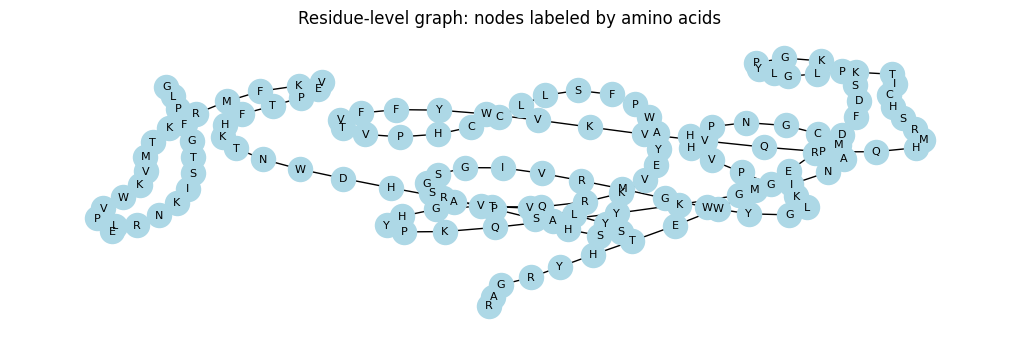

In [10]:
import matplotlib.pyplot as plt
import networkx as nx

G = all_graphs[0]
seq = dummy_sequences[0]

plt.figure(figsize=(10, 3))
pos = nx.spring_layout(G, seed=42)

# Node labels: amino acid letters
labels = {i: seq[i] for i in range(len(seq))}

nx.draw(G, pos,
        with_labels=True,
        labels=labels,
        node_color='lightblue',
        node_size=300,
        font_size=8)

plt.title('Residue-level graph: nodes labeled by amino acids')
plt.show()


In [12]:
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 30.6 MB/s eta 0:00:00


In [19]:
ss_map = {'H':0, 'E':1, 'C':2}

In [20]:
ss_labels = torch.tensor([ss_map[G.nodes[n]['ss']] for n in G.nodes], dtype=torch.long)
print([G.nodes[n]['ss'] for n in G.nodes])

['H', 'E', 'C', 'C', 'C', 'E', 'E', 'H', 'E', 'E', 'H', 'C', 'E', 'E', 'H', 'C', 'E', 'E', 'C', 'H', 'C', 'C', 'E', 'C', 'C', 'E', 'H', 'C', 'C', 'E', 'E', 'H', 'E', 'H', 'H', 'C', 'H', 'C', 'H', 'C', 'H', 'H', 'C', 'H', 'E', 'C', 'E', 'H', 'E', 'H', 'H', 'H', 'C', 'E', 'H', 'C', 'H', 'H', 'C', 'C', 'C', 'H', 'C', 'C', 'H', 'E', 'E', 'C', 'E', 'H', 'H', 'C', 'E', 'E', 'H', 'E', 'E', 'C', 'H', 'E', 'H', 'E', 'C', 'E', 'H', 'H', 'C', 'C', 'E', 'E', 'H', 'E', 'E', 'E', 'H', 'C', 'E', 'H', 'E', 'E', 'H', 'E', 'E', 'E', 'H', 'C', 'E', 'H', 'E', 'C', 'E', 'H', 'C', 'E', 'C', 'E', 'C', 'C', 'H', 'E', 'E', 'E', 'H', 'C', 'H', 'H', 'C', 'C', 'C', 'E', 'E', 'E', 'C', 'H', 'C', 'C', 'C', 'E', 'C', 'H', 'C', 'C', 'E', 'C', 'H', 'E', 'H', 'C', 'E', 'C']


In [22]:
from torch_geometric.data import Data
import numpy as np

all_data = []

ss_map = {'H':0, 'E':1, 'C':2}

for G in all_graphs:
    # embeddings
    x = np.vstack([G.nodes[n]['embedding'] for n in G.nodes])
    x = torch.tensor(x, dtype=torch.float)

    # edges
    edge_index = np.array(list(G.edges)).T
    edge_index = torch.tensor(edge_index, dtype=torch.long)

    # labels
    ss_labels = torch.tensor([ss_map[G.nodes[n]['ss']] for n in G.nodes], dtype=torch.long)
    print([G.nodes[n]['ss'] for n in G.nodes])
    disorder_labels = torch.tensor([G.nodes[n]['disorder'] for n in G.nodes], dtype=torch.float)
    sasa_labels = torch.tensor([G.nodes[n]['sasa'] for n in G.nodes], dtype=torch.float)
    binding_site_labels = torch.tensor([G.nodes[n]['binding_site'] for n in G.nodes], dtype=torch.float)

    data = Data(x=x, edge_index=edge_index,
                ss_labels=ss_labels,
                disorder_labels=disorder_labels,
                sasa_labels=sasa_labels,
                binding_site_labels=binding_site_labels)
    all_data.append(data)

['H', 'E', 'C', 'C', 'C', 'E', 'E', 'H', 'E', 'E', 'H', 'C', 'E', 'E', 'H', 'C', 'E', 'E', 'C', 'H', 'C', 'C', 'E', 'C', 'C', 'E', 'H', 'C', 'C', 'E', 'E', 'H', 'E', 'H', 'H', 'C', 'H', 'C', 'H', 'C', 'H', 'H', 'C', 'H', 'E', 'C', 'E', 'H', 'E', 'H', 'H', 'H', 'C', 'E', 'H', 'C', 'H', 'H', 'C', 'C', 'C', 'H', 'C', 'C', 'H', 'E', 'E', 'C', 'E', 'H', 'H', 'C', 'E', 'E', 'H', 'E', 'E', 'C', 'H', 'E', 'H', 'E', 'C', 'E', 'H', 'H', 'C', 'C', 'E', 'E', 'H', 'E', 'E', 'E', 'H', 'C', 'E', 'H', 'E', 'E', 'H', 'E', 'E', 'E', 'H', 'C', 'E', 'H', 'E', 'C', 'E', 'H', 'C', 'E', 'C', 'E', 'C', 'C', 'H', 'E', 'E', 'E', 'H', 'C', 'H', 'H', 'C', 'C', 'C', 'E', 'E', 'E', 'C', 'H', 'C', 'C', 'C', 'E', 'C', 'H', 'C', 'C', 'E', 'C', 'H', 'E', 'H', 'C', 'E', 'C']
['H', 'E', 'C', 'H', 'H', 'H', 'C', 'E', 'E', 'C', 'H', 'H', 'C', 'H', 'E', 'E', 'E', 'H', 'H', 'H', 'C', 'C', 'H', 'H', 'H', 'E', 'H', 'E', 'C', 'H', 'H', 'C', 'C', 'H', 'H', 'H', 'C', 'E', 'E', 'H', 'C', 'E', 'E', 'C', 'C', 'H', 'C', 'C', 'E', 'H'

In [23]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(all_data, batch_size=8, shuffle=True)

In [24]:
import torch
from torch_geometric.nn import GCNConv

class HierarchicalModel(torch.nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        self.ss_gnn = GCNConv(embed_dim, 64)
        self.disorder_gnn = GCNConv(embed_dim + 64, 32)
        self.sa_gnn = GCNConv(embed_dim + 64 + 32, 16)
        self.binding_site_gnn = GCNConv(embed_dim + 64 + 32 + 16, 2)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        ss = torch.relu(self.ss_gnn(x, edge_index))           # [N,64]
        x1 = torch.cat([x, ss], dim=1)

        disorder = torch.relu(self.disorder_gnn(x1, edge_index)) # [N,32]
        x2 = torch.cat([x1, disorder], dim=1)

        sa = torch.relu(self.sa_gnn(x2, edge_index))          # [N,16]
        x3 = torch.cat([x2, sa], dim=1)

        binding_site_logits = self.binding_site_gnn(x3, edge_index)  # [N,2]
        return binding_site_logits, ss, disorder, sa


In [25]:
criterion_ss = torch.nn.CrossEntropyLoss()
criterion_disorder = torch.nn.BCEWithLogitsLoss()
criterion_sa = torch.nn.MSELoss()
criterion_binding = torch.nn.BCEWithLogitsLoss()

In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = HierarchicalModel(embed_dim=embeddings.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(50):
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()

        binding_logits, ss_pred, disorder_pred, sa_pred = model(data)

        # SS prediction: shape [N,64] → need [N,C], dummy_ss_labels should be int class labels
        loss_ss = criterion_ss(ss_pred, data.ss_labels)

        # Disorder: [N,32] → make a single prediction per residue; for now take mean across dim
        disorder_pred_mean = disorder_pred.mean(dim=1)
        loss_disorder = criterion_disorder(disorder_pred_mean, data.disorder_labels)

        # SA: [N,16] → mean across dim
        sa_pred_mean = sa_pred.mean(dim=1)
        loss_sa = criterion_sa(sa_pred_mean, data.sasa_labels)

        # Binding site: [N,2]; for binary, take logits for positive class
        binding_logits_pos = binding_logits[:,1]
        loss_binding = criterion_binding(binding_logits_pos, data.binding_site_labels)

        # Combine
        total = loss_ss + loss_disorder + loss_sa + loss_binding
        total.backward()
        optimizer.step()
        total_loss += total.item()

    print(f"Epoch {epoch} Loss: {total_loss/len(train_loader):.4f}")


Epoch 0 Loss: 5.3656
Epoch 1 Loss: 4.5697
Epoch 2 Loss: 3.9404
Epoch 3 Loss: 3.5939
Epoch 4 Loss: 3.5037
Epoch 5 Loss: 3.4920
Epoch 6 Loss: 3.4730
Epoch 7 Loss: 3.4767
Epoch 8 Loss: 3.4708
Epoch 9 Loss: 3.4626
Epoch 10 Loss: 3.4550
Epoch 11 Loss: 3.4568
Epoch 12 Loss: 3.4512
Epoch 13 Loss: 3.4524
Epoch 14 Loss: 3.4495
Epoch 15 Loss: 3.4387
Epoch 16 Loss: 3.4407
Epoch 17 Loss: 3.4354
Epoch 18 Loss: 3.4328
Epoch 19 Loss: 3.4464
Epoch 20 Loss: 3.4348
Epoch 21 Loss: 3.4240
Epoch 22 Loss: 3.4233
Epoch 23 Loss: 3.4323
Epoch 24 Loss: 3.4304
Epoch 25 Loss: 3.4272
Epoch 26 Loss: 3.4289
Epoch 27 Loss: 3.4207
Epoch 28 Loss: 3.4187
Epoch 29 Loss: 3.4159
Epoch 30 Loss: 3.4116
Epoch 31 Loss: 3.4115
Epoch 32 Loss: 3.4162
Epoch 33 Loss: 3.4108
Epoch 34 Loss: 3.4128
Epoch 35 Loss: 3.4052
Epoch 36 Loss: 3.4052
Epoch 37 Loss: 3.3984
Epoch 38 Loss: 3.3998
Epoch 39 Loss: 3.4031
Epoch 40 Loss: 3.3976
Epoch 41 Loss: 3.3955
Epoch 42 Loss: 3.3900
Epoch 43 Loss: 3.3963
Epoch 44 Loss: 3.3867
Epoch 45 Loss: 3.387